In [131]:
# v5: change hadcrut to C&W
# v9: add constant offset method for adjusting cmip6 temps
# v10: add more plots (scatter AA vs gap, and letterboxes)
# v11: Add filter to drop EC-Earth model version with missing historical data, and new updates to plot

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import xarray as xr
import os
import glob
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import scipy.stats as stats

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    
    df_hist = df_hist[(df_hist['year'] > t_bnds[0]) & (df_hist['year'] < t_bnds[1])]
    
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [132]:
### set up and read in temp data

out_dfs = {}

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=20

#exp='ssp370'
#exp='ssp370'
exp='ssp126'


temp_correction_method = 'scale' #options are 'scale', 'offset' or 'None'
#temp_correction_method = 'offset' 
#temp_correction_method = 'None' 


## observations
CW_file = 'int_outputs/temperature_CW/CW_tas.csv'

Obs_df = preprocess_obs(pd.read_csv(CW_file), window=window)
obs_set = 'Cowtan & Way'


### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available
### define one tas_df used for both plots, this contains all ensemble members

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=False)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on='Model')
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
print(len(models))


45


In [133]:

### define a first ensemble member version of tas_df

# this (somewhat hacky) code tries ensemble members in the order below ...
# to see what label the first member for each model has
member_labels_to_try = ['r1i1p1f1', 'r2i1p1f1', 'r1i1p2f1', 'r1i1p1f2', 'r1i2p1f1', 'r1i1p1f3', 'r4i1p1f1']

tas_df_1st_mem = tas_df[tas_df['Ensemble_member']==member_labels_to_try[0]]
for model in models:
    df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)
models_1st_mem = tas_df_1st_mem['Model'].unique()
remaining_models = set(models).difference(models_1st_mem)
print(len(remaining_models))

i=1
for i in range(1,len(member_labels_to_try)):    
    df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
    tas_df_1st_mem = pd.concat([tas_df_1st_mem, df_to_append])

    for model in models:
        df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
        if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
            tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

    models_1st_mem = tas_df_1st_mem['Model'].unique()
    remaining_models = set(models).difference(models_1st_mem)

    print(len(remaining_models))
    i=i+1
#print(remaining_models)
print(len(tas_df_1st_mem['Model'].unique()))
print(len(tas_df_1st_mem[tas_df_1st_mem['year']==1850]))

12
12


/tmp/ipykernel_959/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_959/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


11
3
3


/tmp/ipykernel_959/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_959/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_959/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


1
0
45
45


/tmp/ipykernel_959/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


In [134]:
### drop any model without full length run available 
for model in models:
    df_test = tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    #print(df_test.year.max())
    if df_test.year.max() < 2099:
        print("length check: ", model)
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

### drop model EC-Earth-Veg-LR as the historical run is missing years
for model in models:
    df_test = tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    #print(df_test.year.max())
    if not 2005 in df_test.year.values:
        print("at least one complete historical run check:", model)
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

for model in models:
    df_test = tas_df[tas_df['Model']==model]
    if not 2005 in df_test.year.values:
        print("at least one complete historical run check:" + model)
        tas_df.drop(tas_df[tas_df['Model']==model].index, inplace=True)
    

for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if not 2005 in df_test.year.values:
            print(model+ens + '  incomplete')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
        

### drop ensemble members which only have a historical run from tas_df
print(len(tas_df))
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if not exp in df_test['Experiment'].unique():
            #print(model+ens+'  no ssp245')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

### check whether any ensemble members are incomplete
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if df_test.year.max() < 2099:
            #print(model+ens + '  incomplete')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

## update models to represent the final list
models = tas_df['Model'].unique()
print(len(models))

at least one complete historical run check: EC-Earth3-Veg-LR
at least one complete historical run check:EC-Earth3-Veg-LR
ACCESS-CM2r3i1p1f1  incomplete


/tmp/ipykernel_959/1945774701.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_959/1945774701.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


FIO-ESM-2-0r2i1p1f1  incomplete
FIO-ESM-2-0r3i1p1f1  incomplete
IPSL-CM6A-LRr14i1p1f1  incomplete
KACE-1-0-Gr2i1p1f1  incomplete
KACE-1-0-Gr3i1p1f1  incomplete
UKESM1-0-LLr5i1p1f2  incomplete
UKESM1-0-LLr6i1p1f2  incomplete
UKESM1-0-LLr7i1p1f2  incomplete
66202


/tmp/ipykernel_959/1945774701.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_959/1945774701.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


39848


/tmp/ipykernel_959/1945774701.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]


39848
44


In [135]:
global_warming_obs = float(Obs_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Obs_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Obs_df.dropna().tail(1)['year'])


for temp_thresh in [1.5, 2]:

    Model = []
    No_arctic = []
    World = []
    
    M_df = pd.DataFrame(columns=tas_df_1st_mem.columns)

    blues = []
    reds = []
    years = []

    adjusted_up = 0
    adjusted_down = 0
    
    for m in models:
        #print(m)
        m_df = tas_df_1st_mem[tas_df_1st_mem['Model']==m] #use the 1st ens mem only df
        
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

        offset_w = (m_df[m_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
        offset_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]

        
        if offset_w > 0:
            adjusted_up +=1
        else:
            adjusted_down +=1
        
        if temp_correction_method == 'scale':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom']/ratio_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom'] - offset_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom'] - offset_na)
        elif temp_correction_method == 'None':
            m_df['adjusted_world_tas_anom']= m_df['rolling_world_anom']
            m_df['adjusted_no_arctic_tas_anom']= m_df['rolling_no_arctic_anom']
            
        m_df_plot = m_df[m_df['year'] >= obs_year]

        blues.append(np.array(m_df_plot['adjusted_world_tas_anom']))
        reds.append(np.array(m_df_plot['adjusted_no_arctic_tas_anom']))
        years.append(np.array(m_df_plot['year']))

    #         M_df = M_df.append(m_df, ignore_index = True) # Replaced with modern pandas below
        M_df = pd.concat([M_df,m_df],axis=0)

        #also calc crossings
        # if no crossing by 2100 (which is the case for Fgoals-g3 under ssp245) extrapolate using linregress for last 20 years
        
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126
                print(m + ' doesnt cross {} without arctic'.format(temp_thresh))
                m_df_regress = m_df[m_df['year'] > 2080].dropna()
                regression = stats.linregress(m_df_regress['year'], m_df_regress['adjusted_no_arctic_tas_anom'])
                no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])

        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

    out_df = pd.DataFrame({'Model':Model,
                           'No_arctic_crossing_year':No_arctic,
                           'World_crossing_year':World})
    out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
    
    out_dfs[temp_thresh] = out_df

    #mm_mean_df = out_df.groupby()

    ## add observations:
    
    print('observation year: ' + str(obs_year))
    print('{} temp in obs_year:'.format(obs_set) + str(global_warming_obs))
    print('{} temp without AA in obs_year:'.format(obs_set) + str(no_arctic_warming_obs))
    print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
    print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))
    print('mean gap: ' + str(out_df['gap'].mean()) + ' +- ' + str(stats.sem(out_df['gap'].dropna())))
    print('adjusted up: '+ str(adjusted_up))
    print('adjusted down: '+ str(adjusted_down))

observation year: 2013
Cowtan & Way temp in obs_year:1.0193770731829956
Cowtan & Way temp without AA in obs_year:0.9443381329053093
AA contrib:0.07503894027768632
AA contrib (%)0.07361254461352354
mean gap: 6.922815789473691 +- 1.0057981769555389
adjusted up: 24
adjusted down: 20
observation year: 2013
Cowtan & Way temp in obs_year:1.0193770731829956
Cowtan & Way temp without AA in obs_year:0.9443381329053093
AA contrib:0.07503894027768632
AA contrib (%)0.07361254461352354
mean gap: 22.60806666666666 +- 13.103776128773555
adjusted up: 24
adjusted down: 20


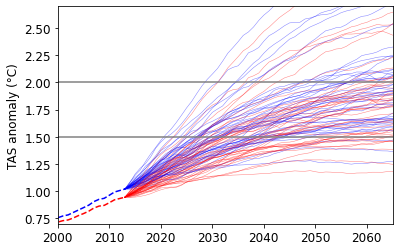

In [136]:
plt.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
plt.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations without AA')


for i in range(len(blues)):
    plt.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
    plt.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')


plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')
plt.savefig('Figures/tas_projections.png', dpi=300)

plt.show()


In [137]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Obs_df.to_csv('Outputs/Processed_{o}_{r}yr_rolling.csv'.format(o=obs_set, r=window))

mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
#out_dfs[temp_thresh]

mean gap for crossing 2C: 22.61 +- 13.1 years


In [138]:
#plt.plot(M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['year'], 
#         M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['adjusted_no_arctic_tas_anom'])
#plt.xlim(2050, 2100)
#plt.ylim(1.5, 2)
#out_dfs

In [139]:
### now repeat calc with multiple ensemble members

# take 1.5C as threshold for this plot if using sp126
if exp == 'ssp126':
    temp_thresh = 1.5
else:
    temp_thresh = 2

temp_thresh = 1.5  

Model = []
Ensemble_member = []
No_arctic = []
World = []
ME_df = pd.DataFrame()

for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']==exp]['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e]
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        
            offset_w = (me_df[me_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
            offset_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]        
        except:
            print('error on: ' + m + e)
 
        if temp_correction_method == 'scale':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom'] - offset_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom'] - offset_na)
        elif temp_correction_method == 'None':
            me_df['adjusted_world_tas_anom']= me_df['rolling_world_anom']
            me_df['adjusted_no_arctic_tas_anom']= me_df['rolling_no_arctic_anom']
            
        ME_df = pd.concat([ME_df,me_df],axis=0)
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126
                print(m + e + ' doesnt cross {} without arctic'.format(temp_thresh))
                me_df_regress = me_df[me_df['year'] > 2080].dropna()
                regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_no_arctic_tas_anom'])
                no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        if np.isnan(world_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126 
                print(m + e + ' doesnt cross {}'.format(temp_thresh))
                me_df_regress = me_df[me_df['year'] > 2080].dropna()
                regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_world_tas_anom'])
                world_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year (world): {}'.format(str(no_arctic_crossing_year)))
            
        
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 1
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))

In [140]:
len(out_df_ME.Model.unique())

44

In [141]:
out_df_ME[out_df_ME['gap'].isnull()==True]

,Model,Ensemble_member,No_arctic_crossing_year,World_crossing_year,gap
87,FGOALS-g3,r1i1p1f1,NaN,NaN,NaN
94,IITM-ESM,r1i1p1f1,NaN,NaN,NaN
104,KIOST-ESM,r1i1p1f1,NaN,NaN,NaN
105,MCM-UA-1-0,r1i1p1f2,NaN,2046.907,NaN
118,MPI-ESM1-2-HR,r1i1p1f1,NaN,2044.613,NaN
119,MPI-ESM1-2-HR,r2i1p1f1,NaN,2059.367,NaN
120,MPI-ESM1-2-LR,r10i1p1f1,NaN,2083.765,NaN
121,MPI-ESM1-2-LR,r1i1p1f1,NaN,2043.686,NaN
123,MPI-ESM1-2-LR,r3i1p1f1,NaN,2047.974,NaN
124,MPI-ESM1-2-LR,r4i1p1f1,NaN,2048.286,NaN


In [142]:
if exp == 'ssp126':
    out_df_ME.dropna(inplace=True)
    
    #also exclude the model MPI-ESM1-2-LR from the multi-ensemble member DF. 
    #since, 8 out of 9 members are nans, so showing the final member only in panel b is misleading
    out_df_ME.drop(out_df_ME[out_df_ME['Model'] == 'MPI-ESM1-2-LR'].index, inplace = True)

models = list(set(out_df_ME['Model']))

ensemble_members = [out_df_ME[out_df_ME['Model']==model].shape[0] for model in models]

ensemble_members = [np.max(out_df_ME[out_df_ME['Model']==model]['gap']) - np.min(out_df_ME[out_df_ME['Model']==model]['gap']) for model in models]

ensemble_members = pd.DataFrame({'model':models,'members':ensemble_members})

ensemble_members = ensemble_members.sort_values('members').iloc[::-1]

7.068684210526337


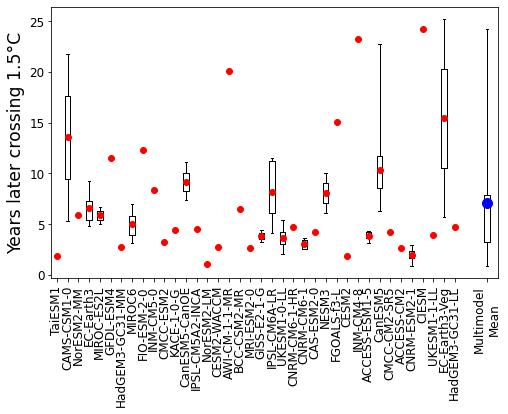

In [143]:
## plot

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]
means = np.array([list(v)[0] for v in vectors])

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=True,
            meanprops={'marker':'o',
              'markerfacecolor':'r',
              'markeredgecolor':'r'})

mm_shift = 2

ax.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'b',
                      'markeredgecolor':'b'},
          vert=True)

print(np.nanmean(means))
ax.set_xlim(-0.5,len(vectors)+mm_shift+1)
ax.set_xticklabels(list(models)+['Multimodel\nMean'],rotation=90)
ax.set_ylabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')


plt.show()

In [144]:
ordered_models = pd.DataFrame({'Model': models,
                               'Ensemble_members_count': None}).set_index('Model')
for model in ordered_models.index:
    count = len(out_df_ME[out_df_ME['Model']==model]['Ensemble_member'].unique())
    ordered_models['Ensemble_members_count'][model] = count

single_mem_models = ordered_models[ordered_models['Ensemble_members_count']==1]
multi_mem_models = ordered_models[ordered_models['Ensemble_members_count'] != 1]

#sort alphabetically for each category
single_mem_models.sort_index(inplace=True)
single_mem_models = single_mem_models[::-1]
single_mem_models['label'] = single_mem_models.index

multi_mem_models.sort_index(inplace=True)
multi_mem_models = multi_mem_models[::-1]
multi_mem_models['name'] = multi_mem_models.index
multi_mem_models['count'] = multi_mem_models['Ensemble_members_count'].apply(str)
multi_mem_models['label'] = multi_mem_models['name'] + ' (' + multi_mem_models['count'] + ')'

#recombine
ordered_models = pd.concat([multi_mem_models, single_mem_models])
ordered_models['name'] = ordered_models.index
ordered_models['count'] = ordered_models['Ensemble_members_count'].apply(str)

ordered_models['label'] = ordered_models['name'] + ' (' + ordered_models['count'] + ')'
ordered_models['label'] = ordered_models['label'].apply(lambda x: x.replace(" (1)", ""))
#ordered_models
#print(ordered_models)

In [145]:
print((out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']).median())
print((out_df['No_arctic_crossing_year'].median() - out_df['World_crossing_year'].median()))
    

9.307999999999993
6.333000000000084


In [146]:
print((out_df.dropna()['No_arctic_crossing_year'] - out_df.dropna()['World_crossing_year']).mean())
print((out_df.dropna()['No_arctic_crossing_year'].mean() - out_df.dropna()['World_crossing_year'].mean()))
out_df['gap'].mean()

22.60806666666666
22.608066666666446


22.60806666666666

Temp Thresh: 1.5
2038.3472894736847 1.8280878788775037 2032.4228292682922 1.1425198241875332
gap:  5.924460205392506 +- 1.0057981769555389
% early 0.386026484712556
Temp Thresh: 2
2070.45 15.492559663700924 2051.380619047619 3.2307846743154136
gap:  19.069380952380925 +- 13.103776128773557
% early 0.4018836870891675


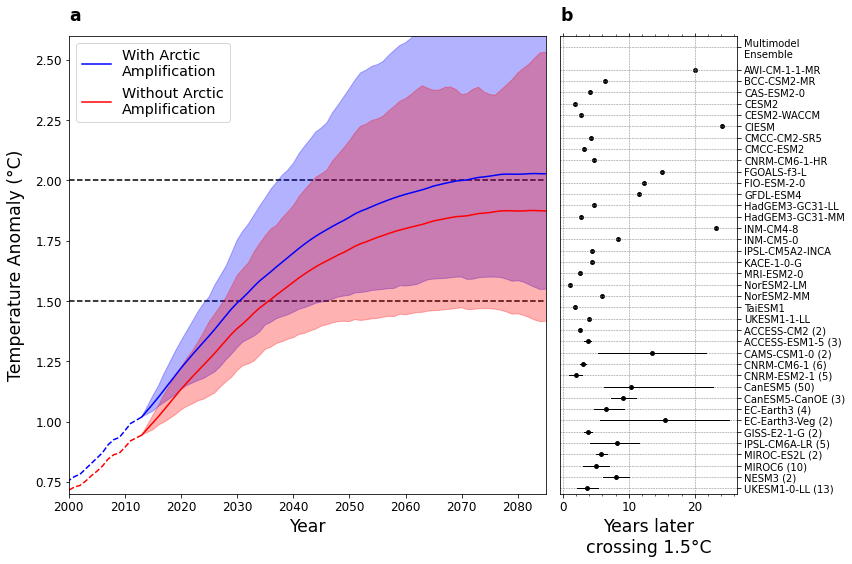

In [147]:
## combine both plots
add_ind_crossing_scatters=True
 
#models = ensemble_members['model']

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in ordered_models.index]

means = np.array([list(v)[0] for v in vectors])
multi_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in multi_mem_models.index]
single_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in single_mem_models.index]
mean_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'].mean() for m in ordered_models.index]


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8), gridspec_kw={'width_ratios': [2.7, 1]})
plt.rcParams['font.size'] = '12'

#for i in range(len(blues)):
#    ax1.plot(years[i], blues[i],
#             c='b', alpha=0.25, linewidth=0.25)
#    ax1.plot(years[i], reds[i], 
#             c='r', alpha=0.25, linewidth=0.25)

ax1.axhline(2, color='k',ls='--', zorder=0)
ax1.axhline(1.5, color='k',ls='--', zorder=0)

## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', lw=1.5)
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', lw=1.5)

# legend_without_duplicate_labels(ax1,fontsize='large')
means_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].mean().dropna()
means_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].mean().dropna()
ax1.plot(means_blue.index.values,means_blue.values,lw=1.5,color='b', linestyle='-', label='With Arctic\nAmplification')
ax1.plot(means_red.index.values,means_red.values,lw=1.5,color='r', linestyle='-', label='Without Arctic\nAmplification')

quantiles=[0.10, 0.90]
bottom_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[0]).dropna()
top_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[1]).dropna()
bottom_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[0]).dropna()
top_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[1]).dropna()

ax1.fill_between(means_blue.index.values, bottom_blue.values, top_blue.values, color='b', alpha=0.3)
ax1.fill_between(means_red.index.values, bottom_red.values, top_red.values, color='r', alpha=0.3)


#if add_ind_crossing_scatters:
#    ax1.scatter(out_dfs[1.5]['World_crossing_year'], np.full(len(out_dfs[1.5]), 0.95+np.random.rand(len(out_dfs[1.5]))*0.015), marker='x', color='b', s=1)
#    ax1.scatter(out_dfs[1.5]['No_arctic_crossing_year'], np.full(len(out_dfs[1.5]), 0.9+np.random.rand(len(out_dfs[1.5]))*0.015), marker='x', color='r', s=1)
    
#    ax1.scatter(out_dfs[2]['World_crossing_year'], np.full(len(out_dfs[2]), 1.2+np.random.rand(len(out_dfs[1.5]))*0.015), marker='x', color='b', s=1)
#    ax1.scatter(out_dfs[2]['No_arctic_crossing_year'], np.full(len(out_dfs[2]), 1.15+np.random.rand(len(out_dfs[1.5]))*0.015), marker='x', color='r', s=1)
    
    #for i in range(0, len(out_dfs[1.5])):
    #    ax1.arrow(out_dfs[1.5]['World_crossing_year'][i], 0.95, 
    #              out_dfs[1.5]['No_arctic_crossing_year'][i]-out_dfs[1.5]['World_crossing_year'][i], -0.05,
    #              lw=0.5, alpha=0.5)
    #for i in range(0, len(out_dfs[2])):
    #    ax1.arrow(out_dfs[2]['World_crossing_year'][i], 1.2, 
    #              out_dfs[2]['No_arctic_crossing_year'][i]-out_dfs[2]['World_crossing_year'][i], -0.05,
    #›              lw=0.5, alpha=0.5)
#ax1.plot([],[],lw=0.9,label='CMIP6 Models',color='b')
#ax1.plot([],[],lw=0.9,label='CMIP6 Models\nWithout AA',color='r')            
ax1.legend(fontsize='large', loc='upper left')


ax1.set_xlim(2000,2085)
ax1.set_ylim(0.7, 2.6)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')

#ax1.yaxis.tick_left()
#ax1.yaxis.set_label_position('left')


###########################################
ax2.scatter(mean_vectors, ordered_models['label'], c='black', s=15)

ax2.boxplot(multi_mem_vectors,positions=np.arange(len(multi_mem_vectors)),whis=[0, 100],
           showmeans=False, vert=False, showbox=True, showfliers=False, widths=0,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'},
           boxprops={})

mm_shift = 1

ax2.boxplot(out_dfs[1.5]['gap'],positions=[len(multi_mem_vectors)+len(single_mem_vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0, 100], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years later\ncrossing {temp_thresh}°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticks(np.delete(np.arange(len(vectors)+mm_shift+1), -2, 0))
ax2.set_yticklabels(list(ordered_models['label'])+['Multimodel\nEnsemble'],rotation=0, fontsize='small')  
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')


markersize=100
marker='o'
for thresh in [1.5,2]:
    
    out_df = out_dfs[thresh]
    
    #x,y = np.median(out_df['No_arctic_crossing_year']), np.median(out_df['World_crossing_year'])
    x,y = np.mean(out_df['No_arctic_crossing_year']), np.mean(out_df['World_crossing_year'])
    z = stats.sem(out_df['gap'], nan_policy='omit')
    x_e, y_e = stats.sem(out_df['No_arctic_crossing_year'], nan_policy='omit'), stats.sem(out_df['World_crossing_year'], nan_policy='omit')
    #ax1.scatter(x,thresh,color='r',marker=marker,s=markersize)
    #ax1.scatter(y,thresh,color='b',marker=marker,s=markersize)
    
    print(f'Temp Thresh: {thresh}')
    print(x, x_e, y, y_e)
    print('gap: ', x-y, '+-', z)
    print('% early', (x-y)/(x-2023))
    

#plt.text(0, 1, 'b', fontsize='x-large', transform=ax.transAxes)
         
# fig = plt.gcf()



ax1.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15)
ax2.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15)
plt.tight_layout()

plt.savefig('Figures/Combined_{}.png'.format(exp), dpi=300)

#plt.show()

In [148]:
year=2050
def ratio_of_intermodel_spread(year):
    w_e = stats.sem(M_df[M_df['year']==year]['adjusted_world_tas_anom'])
    na_e = stats.sem(M_df[M_df['year']==year]['adjusted_no_arctic_tas_anom'])
    print(w_e, na_e)
    print(((w_e-na_e)/na_e))

#for year in np.arange(2040, 2095, 1):
#    ratio_of_intermodel_spread(year)
ratio_of_intermodel_spread(year)

0.053488400216843486 0.04851827406942315
0.10243823059964487


In [149]:
print('number of models: ', len(M_df[M_df['year']==2090]))
print('number of ensemble members: ', len(out_df_ME))

number of models:  44
number of ensemble members:  134


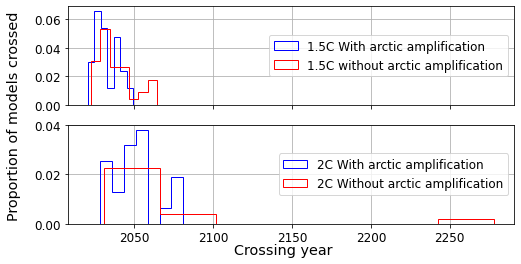

In [150]:
### cumulative freq plot
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 4), sharex=True)

# plot the cumulative histogram
cumul=False
n_bins=7
if cumul:
    n_bins = 1000
n, bins, patches = ax1.hist(out_dfs[1.5]['World_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='1.5C With arctic amplification', color='blue')

n, bins, patches = ax1.hist(out_dfs[1.5]['No_arctic_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='1.5C without arctic amplification', color='red')

n, bins, patches = ax2.hist(out_dfs[2]['World_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='2C With arctic amplification', color='blue')

n, bins, patches = ax2.hist(out_dfs[2]['No_arctic_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='2C Without arctic amplification', color='red')

for ax in ax1, ax2:
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('')

fig.supxlabel('Crossing year')
fig.supylabel('Proportion of models crossed')

plt.show()

In [151]:


out_dfs[1.5]['thresh'] = '1.5'
out_dfs[2]['thresh'] = '2'

out_dfs_concat = pd.concat([out_dfs[1.5], out_dfs[2]])

"""
g = sns.displot(
    data=out_dfs_concat, x="crossing year", hue="sex", row="thresh",
    kind="kde", height=4, aspect=.7,
)
g.set_axis_labels("Density (a.u.)", "Flipper length (mm)")
g.set_titles("{col_name} penguins")
"""

'\ng = sns.displot(\n    data=out_dfs_concat, x="crossing year", hue="sex", row="thresh",\n    kind="kde", height=4, aspect=.7,\n)\ng.set_axis_labels("Density (a.u.)", "Flipper length (mm)")\ng.set_titles("{col_name} penguins")\n'

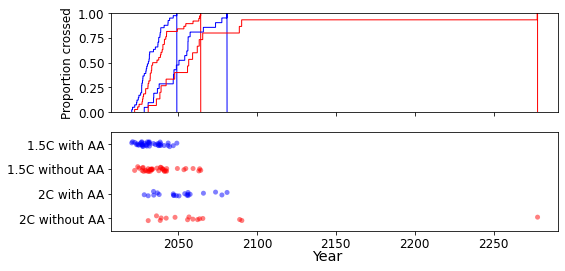

In [152]:
### cumulative plot
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 4), sharex=True)

# plot the cumulative histogram
cumul=True
n_bins=7
if cumul:
    n_bins = 1000

n, bins, patches = ax1.hist(out_dfs[1.5]['World_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='1.5C With arctic amplification', color='blue')

n, bins, patches = ax1.hist(out_dfs[1.5]['No_arctic_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='1.5C without arctic amplification', color='red')

n, bins, patches = ax1.hist(out_dfs[2]['World_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='2C With arctic amplification', color='blue')

n, bins, patches = ax1.hist(out_dfs[2]['No_arctic_crossing_year'], n_bins, density=True, histtype='step',
                           cumulative=cumul, label='2C Without arctic amplification', color='red')

boxes = [out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
        out_dfs[2]['World_crossing_year'], out_dfs[2]['No_arctic_crossing_year']]
#boxes.reverse()

sns.stripplot(ax=ax2, data=boxes, orient='h', 
              palette=['b', 'r', 'b', 'r'], alpha=0.5)

ax2.boxplot(boxes,positions=np.arange(len(boxes)),whis=[0,100],
           showmeans=True, vert=False, 
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'})
"""
for ax in ax1, ax2:
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.get_legend().remove()
"""
ax1.set_ylim(0, 1)


fig.supxlabel('Year')
ax1.set_ylabel('Proportion crossed')
ax2.set_yticks([0,1,2,3])
ax2.set_yticklabels(['1.5C with AA', '1.5C without AA', '2C with AA', '2C without AA'])

plt.show()

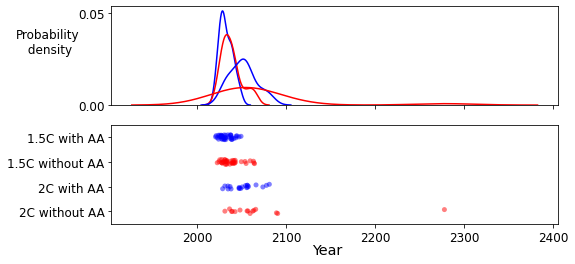

In [153]:
### kde plot
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 4), sharex=True)

# plot the cumulative histogram
cumul=True
n_bins=7
if cumul:
    n_bins = 1000

sns.kdeplot(ax=ax1, data = out_dfs[1.5]['World_crossing_year'], color='blue', legend=False)
sns.kdeplot(ax=ax1, data = out_dfs[1.5]['No_arctic_crossing_year'], color='red', legend=False)
sns.kdeplot(ax=ax1, data = out_dfs[2]['World_crossing_year'], color='blue', legend=False)
sns.kdeplot(ax=ax1, data = out_dfs[2]['No_arctic_crossing_year'], color='red', legend=False)

boxes = [out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
        out_dfs[2]['World_crossing_year'], out_dfs[2]['No_arctic_crossing_year']]
#boxes.reverse()

sns.stripplot(ax=ax2, data=boxes, orient='h', 
              palette=['b', 'r', 'b', 'r'], alpha=0.5)

ax2.boxplot(boxes,positions=np.arange(len(boxes)),whis=[0,100],
           showmeans=True, vert=False, 
            medianprops={'linewidth':0},
            meanprops={'marker':'x', 
                       'markersize':10,
              'markerfacecolor':'black',
              'markeredgecolor':'black'}, zorder=1000)
"""
for ax in ax1, ax2:
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.get_legend().remove()
"""

fig.supxlabel('Year')
ax1.set_ylabel('Probability\n density', rotation=0, labelpad = 30)
ax1.set_yticks([0, 0.05])
ax2.set_yticks([0,1,2,3])
ax2.set_yticklabels(['1.5C with AA', '1.5C without AA', '2C with AA', '2C without AA'])

plt.show()

In [154]:
out_dfs[1.5]

,Model,No_arctic_crossing_year,World_crossing_year,gap,thresh
0,ACCESS-CM2,2025.241,2022.508,2.733,1.5
1,ACCESS-ESM1-5,2033.857,2029.531,4.326,1.5
2,AWI-CM-1-1-MR,2063.654,2043.557,20.097,1.5
3,BCC-CSM2-MR,2036.608,2030.139,6.469,1.5
4,CAMS-CSM1-0,2059.463,2037.726,21.737,1.5
5,CAS-ESM2-0,2028.115,2023.941,4.174,1.5
6,CESM2,2029.449,2027.602,1.847,1.5
7,CESM2-WACCM,2033.309,2030.527,2.782,1.5
8,CIESM,2063.144,2038.965,24.179,1.5
9,CMCC-CM2-SR5,2042.739,2038.474,4.265,1.5


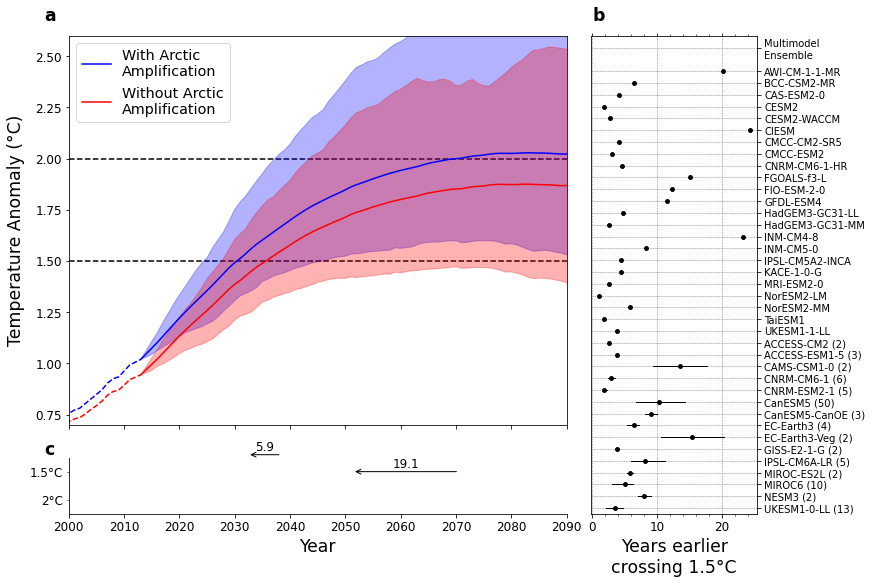

In [155]:
### combine all 4 panels
fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(6, 4)
ax1 = fig.add_subplot(gs[0:-1, :-1])
ax1.axhline(2, color='k',ls='--', zorder=0)
ax1.axhline(1.5, color='k',ls='--', zorder=0)

## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', lw=1.5)
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', lw=1.5)

# legend_without_duplicate_labels(ax1,fontsize='large')
means_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].mean().dropna()
means_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].mean().dropna()
ax1.plot(means_blue.index.values,means_blue.values,lw=1.5,color='b', linestyle='-', label='With Arctic\nAmplification')
ax1.plot(means_red.index.values,means_red.values,lw=1.5,color='r', linestyle='-', label='Without Arctic\nAmplification')

quantiles=[0.10, 0.90]
bottom_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[0]).dropna()
top_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[1]).dropna()
bottom_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[0]).dropna()
top_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[1]).dropna()

ax1.fill_between(means_blue.index.values, bottom_blue.values, top_blue.values, color='b', alpha=0.3)
ax1.fill_between(means_red.index.values, bottom_red.values, top_red.values, color='r', alpha=0.3)
         
ax1.legend(fontsize='large', loc='upper left')


ax1.set_xlim(2000,2090)
ax1.set_ylim(0.7, 2.6)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
#ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
plt.setp(ax1.get_xticklabels(), visible=False)

#############################################################

ax2 = fig.add_subplot(gs[:, -1])


ax2.scatter(mean_vectors, ordered_models['label'], c='black', s=15, zorder=1000)

ax2.boxplot(multi_mem_vectors,positions=np.arange(len(multi_mem_vectors)),whis=[5, 95],
           showmeans=False, vert=False, showbox=True, showfliers=False, widths=0,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'},
           boxprops={})

mm_shift = 1

ax2.boxplot(out_dfs[1.5]['gap'],positions=[len(multi_mem_vectors)+len(single_mem_vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)

ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years earlier\ncrossing {temp_thresh}°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticks(np.delete(np.arange(len(vectors)+mm_shift+1), -2, 0))
ax2.set_yticklabels(list(ordered_models['label'])+['Multimodel\nEnsemble'],rotation=0, fontsize='small')  
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')



ax4 = fig.add_subplot(gs[5, :-1], sharex=ax1)
#ax4.set_title('c')


boxes = [out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
        out_dfs[2]['World_crossing_year'], out_dfs[2]['No_arctic_crossing_year']]
boxes.reverse()

#sns.stripplot(ax=ax4, data=boxes, orient='h', 
#              palette=['b', 'r', 'b', 'r'], alpha=0.5)

colors = ['red', 'blue', 'red', 'blue']
bplot = ax4.boxplot(boxes,positions=np.arange(len(boxes)),whis=[5,95], showfliers=False,
           showmeans=True, vert=False,  patch_artist=True,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':8,
              'markerfacecolor':'black',
              'markeredgecolor':'black'}, 
            zorder=1000)


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.3)


ax4.set_xlabel('Year',fontsize='x-large')
ax4.set_yticks([0,1,2,3])
#ax4.set_yticklabels(['1.5C', '', '2C', ''])
ax4.set_yticklabels(['', '', '', ''])
ax4.yaxis.set_minor_locator(ticker.FixedLocator([0.5,2.5]))
ax4.yaxis.set_minor_formatter(ticker.FixedFormatter(['2°C','1.5°C']))
ax4.tick_params(axis='y', which='major', length=0)

#ax4.set_ylabel('Threshold (°C)',fontsize='x-large', labelpad=10)

ax1.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15, x=-0.05)
ax2.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15, x=0.01)
#ax3.set_title('c', weight='bold', fontsize='x-large', loc='left', pad=15)
ax4.set_title('c', y=0.95, weight='bold', fontsize='x-large', loc='left', x =-0.05)
#ax4.annotate("", (2030, 0), (10, 0), arrowprops = dict(arrowstyle="<->"))

y1 = 3.7
delta_y = 0.3
y2 = 2.5

ax4.annotate("", (np.mean(out_dfs[1.5]['World_crossing_year']), y1), 
             xytext=(np.mean(out_dfs[1.5]['No_arctic_crossing_year']), y1), 
             xycoords='data', textcoords='data', 
             arrowprops=dict(arrowstyle="->"), annotation_clip=False)
ax4.annotate("", (np.mean(out_dfs[2]['World_crossing_year']), y2), 
             xytext=(np.mean(out_dfs[2]['No_arctic_crossing_year']), y2), 
             xycoords='data', textcoords='data', 
             arrowprops=dict(arrowstyle="->"), annotation_clip=False)
ax4.annotate("{}".format(str(np.round(np.mean(out_dfs[1.5]['No_arctic_crossing_year']) - np.mean(out_dfs[1.5]['World_crossing_year']), 1))),
             xy=((np.mean(out_dfs[1.5]['World_crossing_year']) + np.mean(out_dfs[1.5]['No_arctic_crossing_year']))/2, y1+delta_y), 
             textcoords='data', 
             annotation_clip=False,
             horizontalalignment='center')
ax4.annotate("{}".format(str(np.round(np.mean(out_dfs[2]['No_arctic_crossing_year']) - np.mean(out_dfs[2]['World_crossing_year']), 1))),
             xy=((np.mean(out_dfs[2]['World_crossing_year']) + np.mean(out_dfs[2]['No_arctic_crossing_year']))/2, y2+delta_y), 
             textcoords='data', 
             annotation_clip=False,
            horizontalalignment='center')
ax4.spines[['top', 'right']].set_visible(False)
#plt.tight_layout()

plt.savefig('Figures/Combined_all_{}.png'.format(exp), dpi=300)
plt.show()

In [156]:
## t-test the distributions

p15 = stats.ttest_ind(out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
                axis=0, equal_var=True, nan_policy='propagate', permutations=100000, 
                alternative='less').pvalue

p2 = stats.ttest_ind(out_dfs[2]['World_crossing_year'], out_dfs[2]['No_arctic_crossing_year'],
                axis=0, equal_var=True, nan_policy='propagate', permutations=100000, 
                alternative='less').pvalue

print('pvalue for difference in means of 1.5 crossing: ', str(p15))
print('pvalue for difference in means of 1.5 crossing: ', str(p2))

pvalue for difference in means of 1.5 crossing:  nan
pvalue for difference in means of 1.5 crossing:  nan


In [157]:
#out_df_nan

In [158]:
#out_df_ME[out_df_ME['gap'] == np.nan]

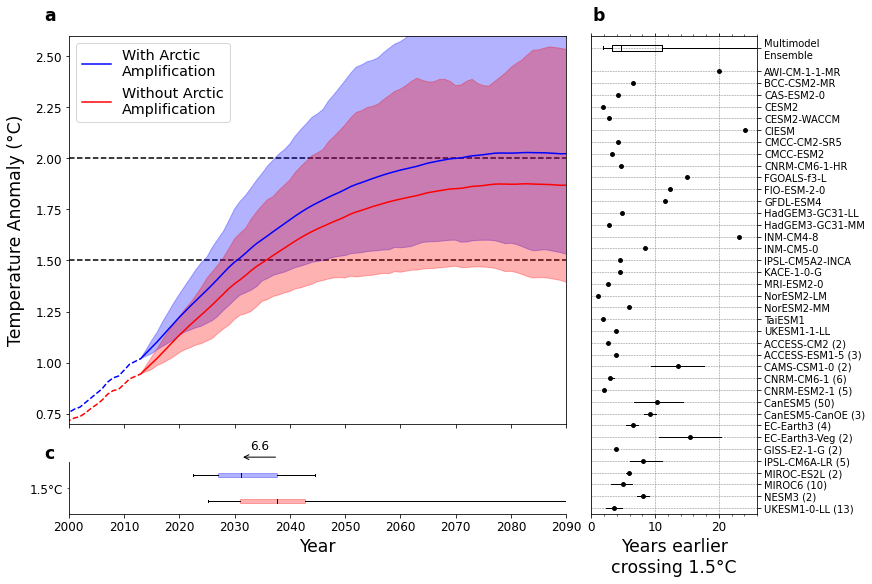

Temp Thresh: 2
2037.758 2031.161
% early 0.4470117902154738


In [159]:
### additional main plot for ssp126 using medians and dropping nans

out_df_nan = out_dfs[1.5]
out_df_nan = out_df_nan.dropna(subset = ['World_crossing_year']) #exclude any models that don't cross in either scenario from analysis
out_df_nan = out_df_nan.replace({np.nan: 10000})
#out_dfs[1.5] = out_dfs[1.5].dropna()

### combine all 4 panels
fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(6, 4)
ax1 = fig.add_subplot(gs[0:-1, :-1])
ax1.axhline(2, color='k',ls='--', zorder=0)
ax1.axhline(1.5, color='k',ls='--', zorder=0)

## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', lw=1.5)
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', lw=1.5)

# legend_without_duplicate_labels(ax1,fontsize='large')
means_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].mean().dropna()
means_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].mean().dropna()
ax1.plot(means_blue.index.values,means_blue.values,lw=1.5,color='b', linestyle='-', label='With Arctic\nAmplification')
ax1.plot(means_red.index.values,means_red.values,lw=1.5,color='r', linestyle='-', label='Without Arctic\nAmplification')

quantiles=[0.10, 0.90]
bottom_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[0]).dropna()
top_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[1]).dropna()
bottom_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[0]).dropna()
top_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[1]).dropna()

ax1.fill_between(means_blue.index.values, bottom_blue.values, top_blue.values, color='b', alpha=0.3)
ax1.fill_between(means_red.index.values, bottom_red.values, top_red.values, color='r', alpha=0.3)
         
ax1.legend(fontsize='large', loc='upper left')


ax1.set_xlim(2000,2090)
ax1.set_ylim(0.7, 2.6)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
#ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
plt.setp(ax1.get_xticklabels(), visible=False)

#############################################################

ax2 = fig.add_subplot(gs[:, -1])


ax2.scatter(mean_vectors, ordered_models['label'], c='black', s=15, zorder=1000)

ax2.boxplot(multi_mem_vectors,positions=np.arange(len(multi_mem_vectors)),whis=[5, 95],
           showmeans=False, vert=False, showbox=True, showfliers=False, widths=0,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'},
           boxprops={})

mm_shift = 1

ax2.boxplot(out_df_nan['gap'],positions=[len(multi_mem_vectors)+len(single_mem_vectors)+mm_shift],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
            medianprops={'color':'black'},
          vert=False)

ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)

#using the infinite crossing years for nans, 95th %ile is infite, so restrict x-axis to see data
if exp == 'ssp126':
    ax2.set_xlim(0, 26)
    
ax2.set_xlabel(f'Years earlier\ncrossing 1.5°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticks(np.delete(np.arange(len(vectors)+mm_shift+1), -2, 0))
ax2.set_yticklabels(list(ordered_models['label'])+['Multimodel\nEnsemble'],rotation=0, fontsize='small')  
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')



ax4 = fig.add_subplot(gs[5, :-1], sharex=ax1)
#ax4.set_title('c')


boxes = [out_df_nan['World_crossing_year'], out_df_nan['No_arctic_crossing_year']]
boxes.reverse()

#sns.stripplot(ax=ax4, data=boxes, orient='h', 
#              palette=['b', 'r', 'b', 'r'], alpha=0.5)

colors = ['red', 'blue']
bplot = ax4.boxplot(boxes,positions=np.arange(len(boxes)),whis=[5,95], showfliers=False,
           showmeans=False, vert=False,  patch_artist=True, 
            medianprops={'color':'black',
                         'markerfacecolor':'black',
              'markeredgecolor':'black'},
            zorder=1000)


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.3)


ax4.set_xlabel('Year',fontsize='x-large')
ax4.set_yticks([0,1])
#ax4.set_yticklabels(['1.5C', '', '2C', ''])
ax4.set_yticklabels(['', ''])
ax4.yaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax4.yaxis.set_minor_formatter(ticker.FixedFormatter(['1.5°C']))
ax4.tick_params(axis='y', which='major', length=0)

#ax4.set_ylabel('Threshold (°C)',fontsize='x-large', labelpad=10)

ax1.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15, x=-0.05)
ax2.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15, x=0.01)
#ax3.set_title('c', weight='bold', fontsize='x-large', loc='left', pad=15)
ax4.set_title('c', y=0.95, weight='bold', fontsize='x-large', loc='left', x =-0.05)
#ax4.annotate("", (2030, 0), (10, 0), arrowprops = dict(arrowstyle="<->"))

y1 = 1.7
delta_y = 0.3
y2 = 2.5

ax4.annotate("", (np.median(out_df_nan['World_crossing_year']), y1), 
             xytext=(np.median(out_df_nan['No_arctic_crossing_year']), y1), 
             xycoords='data', textcoords='data', 
             arrowprops=dict(arrowstyle="->"), annotation_clip=False)
ax4.annotate("{}".format(str(np.round(np.median(out_df_nan['No_arctic_crossing_year']) - np.median(out_df_nan['World_crossing_year']), 1))),
             xy=((np.median(out_df_nan['World_crossing_year']) + np.median(out_df_nan['No_arctic_crossing_year']))/2, y1+delta_y), 
             textcoords='data', 
             annotation_clip=False,
             horizontalalignment='center')
ax4.spines[['top', 'right']].set_visible(False)
#plt.tight_layout()
if exp =='ssp126':
    plt.savefig('Figures/Combined_all_{}.png'.format(exp), dpi=300)
plt.show()


x,y = np.median(out_df_nan['No_arctic_crossing_year']), np.median(out_df_nan['World_crossing_year'])
#z = stats.sem(out_df_nan['gap'], nan_policy='omit')
#x_e, y_e = stats.sem(out_df_nan['No_arctic_crossing_year'], nan_policy='omit'), stats.sem(out_df_nan['World_crossing_year'], nan_policy='omit')
#ax1.scatter(x,thresh,color='r',marker=marker,s=markersize)
#ax1.scatter(y,thresh,color='b',marker=marker,s=markersize)

print(f'Temp Thresh: {thresh}')
print(x, y)
#print('gap: ', x-y, '+-', z)
print('% early', (x-y)/(x-2023))
    

In [160]:
## t-test the distributions

p15 = stats.ttest_ind(out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
                axis=0, equal_var=True, nan_policy='propagate', permutations=100000, 
                alternative='less').pvalue

print('pvalue for difference in means of 1.5 crossing: ', str(p15))


pvalue for difference in means of 1.5 crossing:  nan


In [161]:
print((len(out_dfs[2]['World_crossing_year'])-len(out_dfs[2]['World_crossing_year'].dropna()))
      /len(out_dfs[2]['World_crossing_year']))
print((len(out_dfs[2]['No_arctic_crossing_year'])-len(out_dfs[2]['No_arctic_crossing_year'].dropna()))
      /len(out_dfs[2]['No_arctic_crossing_year']))

0.5227272727272727
0.6590909090909091


In [162]:
out_df_nan

,Model,No_arctic_crossing_year,World_crossing_year,gap,thresh
0,ACCESS-CM2,2025.241,2022.508,2.733,1.5
1,ACCESS-ESM1-5,2033.857,2029.531,4.326,1.5
2,AWI-CM-1-1-MR,2063.654,2043.557,20.097,1.5
3,BCC-CSM2-MR,2036.608,2030.139,6.469,1.5
4,CAMS-CSM1-0,2059.463,2037.726,21.737,1.5
5,CAS-ESM2-0,2028.115,2023.941,4.174,1.5
6,CESM2,2029.449,2027.602,1.847,1.5
7,CESM2-WACCM,2033.309,2030.527,2.782,1.5
8,CIESM,2063.144,2038.965,24.179,1.5
9,CMCC-CM2-SR5,2042.739,2038.474,4.265,1.5


In [163]:
str(np.round(np.mean(out_dfs[1.5]['No_arctic_crossing_year']) - np.mean(out_dfs[1.5]['World_crossing_year']),1))

'5.9'

**now read in arctic amplification calulcated in 'preprocess_AA.ipyb' and scatter against early crossing**

Text(0.5, 1.0, 'slope: 1.08, pvalue: 0.01')

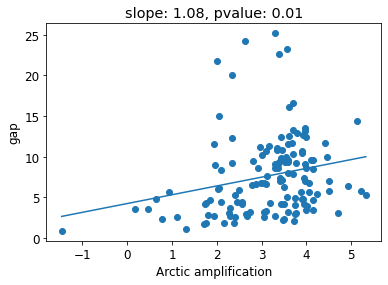

In [164]:
all_files = glob.glob(os.path.join('Outputs/mean_AAs', "*.csv"))
df_AA = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
#df_AA = df_AA[df_AA['Experiment'] == 'historical']
df_AA = df_AA[df_AA['Experiment'] == exp]



df_AA = pd.merge(df_AA, out_df_ME, on=['Model', 'Ensemble_member'], how='left')
df_AA.to_csv('AA_and_crossing_years_{}.csv'.format(exp))
df_AA['earlier_crossing_%'] = 100*df_AA.gap/(df_AA.No_arctic_crossing_year - obs_year)
df_AA = df_AA.dropna()

regression = stats.linregress(df_AA['AA'], df_AA['gap'])
m, c, p = regression.slope, regression.intercept, regression.pvalue
plt.scatter(df_AA.AA, df_AA['gap'])
x = np.arange(df_AA.AA.min(), df_AA.AA.max(), 0.01)
plt.plot(x, m*x + c)
plt.ylabel('gap')
plt.xlabel('Arctic amplification')
plt.title('slope: ' + str(np.round(m, 2)) + ', pvalue: ' + str(np.round(p, 2)))

Text(0, 0.5, 'Early crossing 2C due to AA (%)')

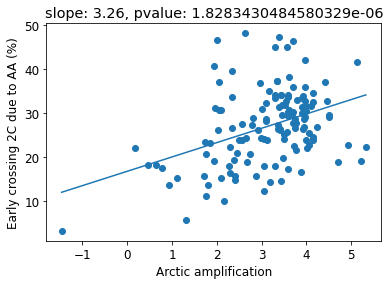

In [165]:

#df_AA = df_AA.groupby('Model')['AA', 'earlier_crossing_%'].mean()
#df_AA = df_AA[df_AA['AA'] > 1.5]
regression = stats.linregress(df_AA['AA'], df_AA['earlier_crossing_%'])
m, c, p = regression.slope, regression.intercept, regression.pvalue
plt.scatter(df_AA.AA, df_AA['earlier_crossing_%'])
x = np.arange(df_AA.AA.min(), df_AA.AA.max(), 0.01)
plt.plot(x, m*x + c)
plt.title('slope: ' + str(np.round(m, 2)) + ', pvalue: ' + str(p))
plt.xlabel('Arctic amplification')
plt.ylabel('Early crossing 2C due to AA (%)')

Text(0.5, 1.0, 'slope: 3.29, pvalue: 0.03')

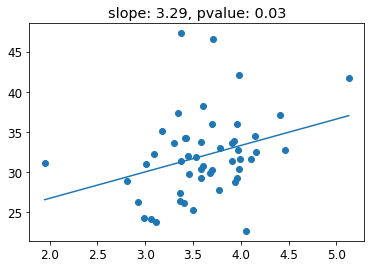

In [166]:
#repeat for a single model with many members
df_AA = df_AA[df_AA['Model'] == 'CanESM5']


regression = stats.linregress(df_AA['AA'], df_AA['earlier_crossing_%'])
m, c, p = regression.slope, regression.intercept, regression.pvalue
plt.scatter(df_AA.AA, df_AA['earlier_crossing_%'])
x = np.arange(df_AA.AA.min(), df_AA.AA.max(), 0.01)
plt.plot(x, m*x + c)
plt.title('slope: ' + str(np.round(m, 2)) + ', pvalue: ' + str(np.round(p, 2)))

**the next cell repeats the plots above, but this time using our adjusted tas projections caluclated in this notebook to calculate AA, rather than the raw data**

Text(0.5, 1.0, 'slope: 3.77, pvalue: 0.0')

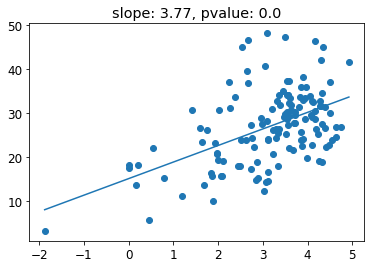

In [167]:
a_A = 0.04325 #fraction of earth north of 66N
a_N = 1- a_A
AA_years = [2015, 2065]
ME_df['adjusted_arctic_tas_anom'] = (ME_df['adjusted_world_tas_anom'] - a_N*ME_df['adjusted_no_arctic_tas_anom'])/a_A
DF = pd.DataFrame()
for model in ME_df.Model.unique():
    df_mod = ME_df[ME_df['Model']==model]
    for ens in df_mod.Ensemble_member.unique():
        df_mod_e = df_mod[df_mod['Ensemble_member']==ens]
        df_mod_e = df_mod_e[df_mod_e['year'] > AA_years[0]]
        df_mod_e = df_mod_e[df_mod_e['year'] <= AA_years[1]]
        arctic_trend = stats.linregress(df_mod_e['year'].values.astype(float), df_mod_e['adjusted_arctic_tas_anom'].values).slope
        world_trend = stats.linregress(df_mod_e['year'].values.astype(float), df_mod_e['adjusted_world_tas_anom'].values).slope    
        AA = arctic_trend/world_trend
        df = pd.DataFrame(columns=['arctic_trend', 'world_trend', 'AA', 'Ensemble_member',
                                      'Model'])
        df.loc[0] = [arctic_trend, world_trend, AA, ens,
                         model]
        DF = pd.concat([DF, df])

    
df_AA = pd.merge(DF, out_df_ME, on=['Model', 'Ensemble_member'], how='left')
df_AA.to_csv('AA_and_crossing_years_{}.csv'.format(exp))
df_AA['earlier_crossing_%'] = 100*df_AA.gap/(df_AA.No_arctic_crossing_year - obs_year)
df_AA = df_AA.dropna()

regression = stats.linregress(df_AA['AA'], df_AA['earlier_crossing_%'])
m, c, p = regression.slope, regression.intercept, regression.pvalue
plt.scatter(df_AA.AA, df_AA['earlier_crossing_%'])
x = np.arange(df_AA.AA.min(), df_AA.AA.max(), 0.01)
plt.plot(x, m*x + c)
plt.title('slope: ' + str(np.round(m, 2)) + ', pvalue: ' + str(np.round(p, 2)))